# MBS Duration Exposure

# Packages

In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Read in Data

In [2]:
df_mtge = (pd.read_parquet(
    path = "mtge.parquet",
    engine = "pyarrow").
    dropna().
    drop(columns = ["field"]))

df_mbs = (pd.read_parquet(
    path = "mbs.parquet",
    engine = "pyarrow").
    dropna().
    drop(columns = ["field"]))

df_duration = (pd.read_parquet(
    path = "mbs_duration.parquet",
    engine = "pyarrow").
    drop(columns = ["field"]))

df = pd.concat([df_mtge, df_mbs, df_duration])

# Background Research

First examine house supply

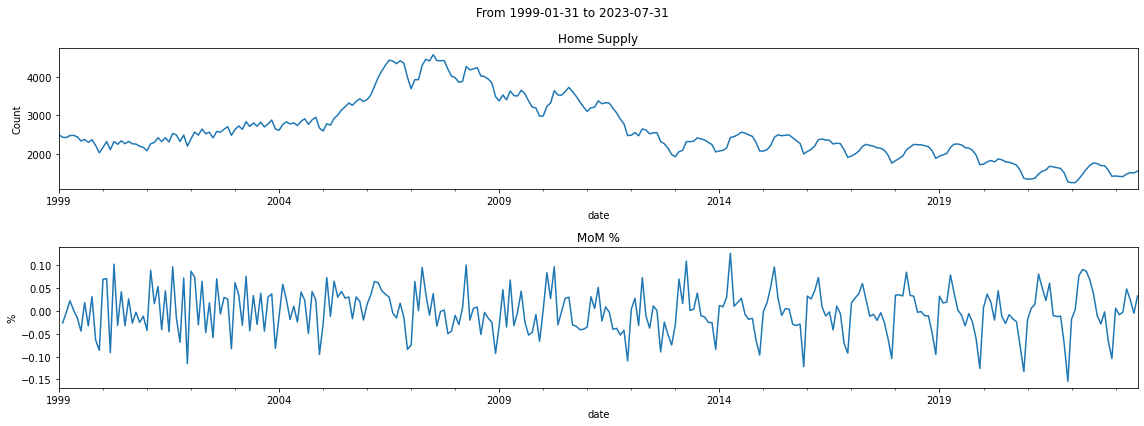

In [6]:
df_home_supply = (df.query(
    "ticker == ['.HOMESUP G Index']").
    pivot(index = "date", columns = "ticker", values = "value").
    rename(columns = {".HOMESUP G Index": "Home Supply"}).
    assign(change = lambda x: x["Home Supply"].pct_change()).
    rename(columns = {"change": "MoM %"}))

fig, axes = plt.subplots(nrows = 2, figsize = (16, 6))

for i, col in enumerate(df_home_supply.columns):

     (df_home_supply[
        col].
        plot(
            ax = axes[i],
            title = col,
            legend = False))

fig.suptitle("From {} to {}".format(
    df_home_supply.index.min().date(),
    df_home_supply.index.max().date()))

axes[0].set_ylabel("Count")
axes[1].set_ylabel("%")

plt.tight_layout()
plt.show()

Look at convexity, the proxy for this is by looking at duration. As rates increase convexity increases as people don't prepay. This extends the maturity (duration) of the MBS thus duration is a relatively good proxy for duration.

In [7]:
df_duration = (df.query(
    "ticker == 'LUMSMD Index'").
    pivot(index = "date", columns = "ticker", values = "value").
    rename(columns = {"LUMSMD Index": "LUMSMD"}).
    assign(z_score = lambda x: (x.LUMSMD - x.LUMSMD.rolling(window = 90).mean()) / x.LUMSMD.rolling(window = 90).std()).
    dropna().
    rename(columns = {"z_score": "30d Rolling Z-Score"}))

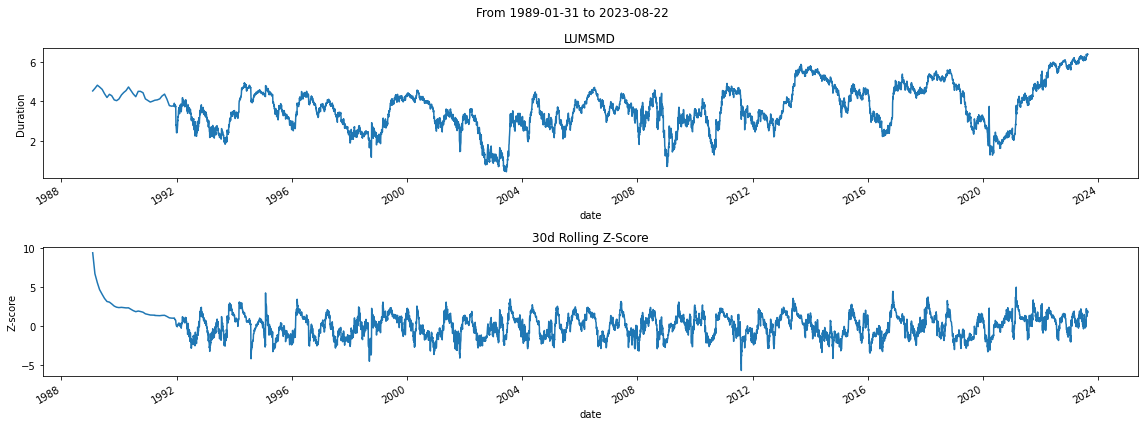

In [8]:
fig, axes = plt.subplots(nrows = 2, figsize = (16, 6))

for i, col in enumerate(df_duration.columns):
    (df_duration[
        col].
        plot(
            ax  = axes[i],
            title = col))

axes[0].set_ylabel("Duration")
axes[1].set_ylabel("Z-score")

fig.suptitle("From {} to {}".format(
    df_duration.index.min().date(),
    df_duration.index.max().date()))

plt.tight_layout()

In this case a standard Mortgage rate model can be made. One will be used with MOVE index and one without. Although most of the work is that 30y mortgage rate is pretty much tied to Treasury Rates

# MBS Rates model

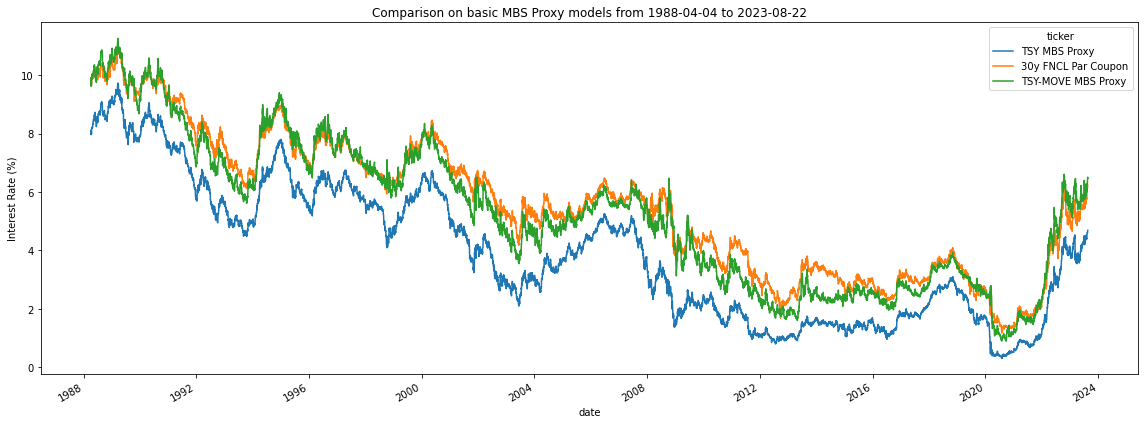

In [9]:
df_mbs_model = (df.query(
    "ticker == ['USGG10YR Index', 'USGG2YR Index', 'MOVE Index', 'MTGEFNCL Index']").
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]).
    pivot(index = "date", columns = "ticker", values = "value").
    dropna().
    assign(
        mbs_proxy = lambda x: (x.USGG10YR + x.USGG2YR) / 2,
        mbs_vol_proxy = lambda x: x.mbs_proxy + (0.014049 * x.MOVE))
    [["mbs_proxy", "MTGEFNCL", "mbs_vol_proxy"]].
    rename(columns = {
        "mbs_proxy": "TSY MBS Proxy",
        "mbs_vol_proxy": "TSY-MOVE MBS Proxy",
        "MTGEFNCL": "30y FNCL Par Coupon"}))

(df_mbs_model.plot(
  ylabel = "Interest Rate (%)",
  figsize = (16,6),
  title = "Comparison on basic MBS Proxy models from {} to {}".format(
      df_mbs_model.index.min().date(),
      df_mbs_model.index.max().date())))

plt.tight_layout()
plt.show()

Running Regression on Mortgage rate models vs. 30y Mortgage Rate

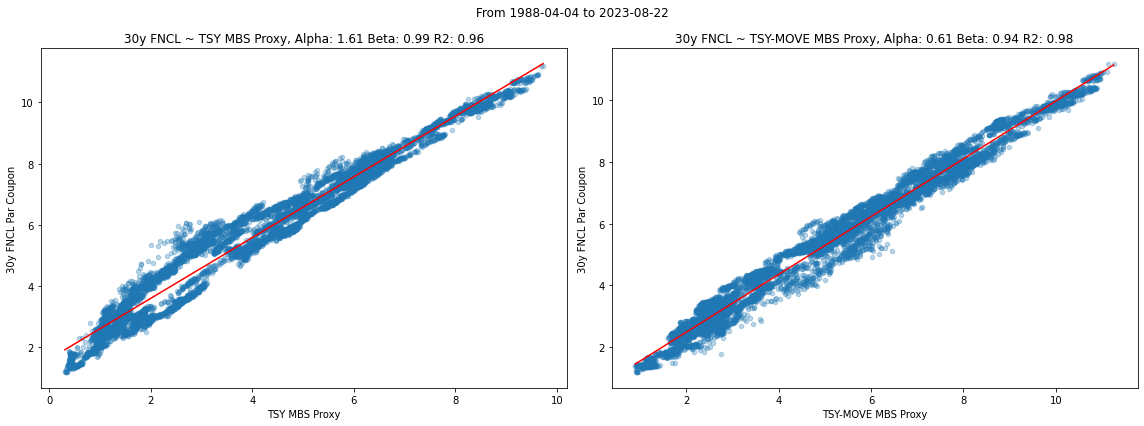

In [15]:
exog_variables = ["TSY MBS Proxy", "TSY-MOVE MBS Proxy"]
fig, axes = plt.subplots(ncols = len(exog_variables), figsize = (16, 6))

for i, col in enumerate(exog_variables):

    (df_mbs_model[
        [col, "30y FNCL Par Coupon"]].
        plot(
            kind = "scatter",
            x = col,
            y = "30y FNCL Par Coupon",
            ax = axes[i],
            alpha = 0.3))

    lm_model = (sm.OLS(
        endog = df_mbs_model["30y FNCL Par Coupon"],
        exog = sm.add_constant(df_mbs_model[col])).
        fit())

    alpha, beta = lm_model.params
    rsquared = lm_model.rsquared

    x = np.linspace(
        start = df_mbs_model[col].min(),
        stop = df_mbs_model[col].max(),
        num = 1_000)

    y = (beta * x) + alpha

    axes[i].plot(x, y, color = "r")
    axes[i].set_title("30y FNCL ~ {}, Alpha: {} Beta: {} R2: {}".format(
        col,
        round(alpha, 2),
        round(beta, 2),
        round(rsquared, 2)))

fig.suptitle("From {} to {}".format(
    df_mbs_model.index.min().date(),
    df_mbs_model.index.max().date()))

plt.tight_layout()
plt.show()

Now examine the betas, unfortunately hard-code the betas from the model (although they are pretty much 1)

In [16]:
df_resid = (df_mbs_model.assign(
    lm1_residuals = lambda x: x["30y FNCL Par Coupon"] - (0.99 * x["TSY MBS Proxy"]),
    lm2_residuals = lambda x: x["30y FNCL Par Coupon"] - (0.94 * x["TSY-MOVE MBS Proxy"]))
    [["lm1_residuals", "lm2_residuals"]].
    assign(
        lm1_residuals = lambda x: (x.lm1_residuals - x.lm1_residuals.mean()) / x.lm1_residuals.std(),
        lm2_residuals = lambda x: (x.lm2_residuals - x.lm2_residuals.mean()) / x.lm2_residuals.std()))

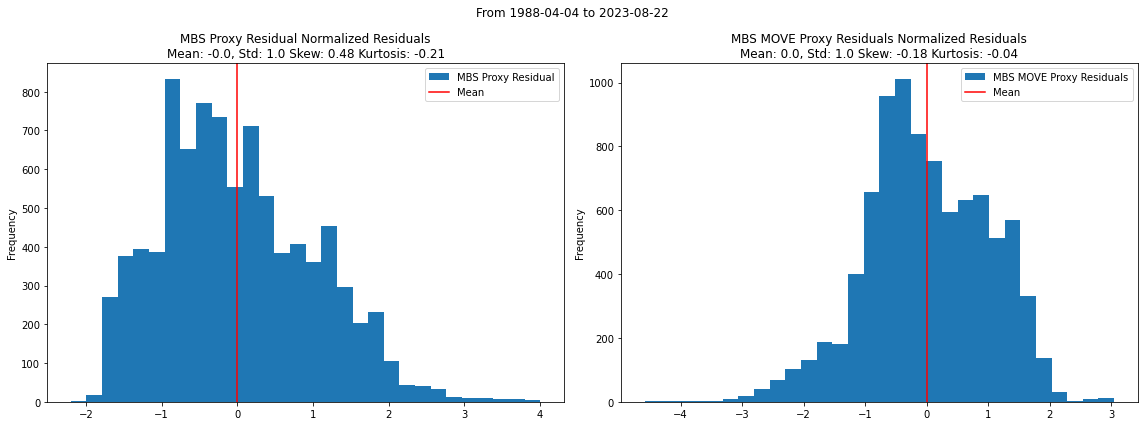

In [18]:
df_resid_plot = (df_resid.rename(columns = {
    "lm1_residuals": "MBS Proxy Residual",
    "lm2_residuals": "MBS MOVE Proxy Residuals"}))

fig, axes = plt.subplots(ncols = 2, figsize = (16, 6))
for i, col in enumerate(df_resid_plot):

    df_tmp = (df_resid_plot[col])
    mean, std, skew, kurtosis = df_tmp.mean(), df_tmp.std(), df_tmp.skew(), df_tmp.kurtosis()

    (df_tmp.plot(
        kind = "hist",
        ax = axes[i],
        bins = 30,
        title = "{} Normalized Residuals\nMean: {}, Std: {} Skew: {} Kurtosis: {}".format(
            col,
            round(mean, 2),
            round(std, 2),
            round(skew, 2),
            round(kurtosis, 2))))

    axes[i].axvline(
        mean,
        color = "red",
        label = "Mean")

    axes[i].legend()


fig.suptitle("From {} to {}".format(
    df_tmp.index.min().date(),
    df_tmp.index.max().date()))

plt.tight_layout()
plt.show()

In [19]:
def _moments(df: pd.DataFrame) -> pd.DataFrame:
    return(pd.DataFrame({
        "mean": [df.value.mean()],
        "Standard Deviation": [df.value.std()],
        "skew": [df.value.skew()],
        "kurtosis": [df.value.kurtosis()]}))

df_resid_moment = (df_resid_plot.reset_index().melt(
    id_vars = "date").
    groupby("ticker").
    apply(_moments))

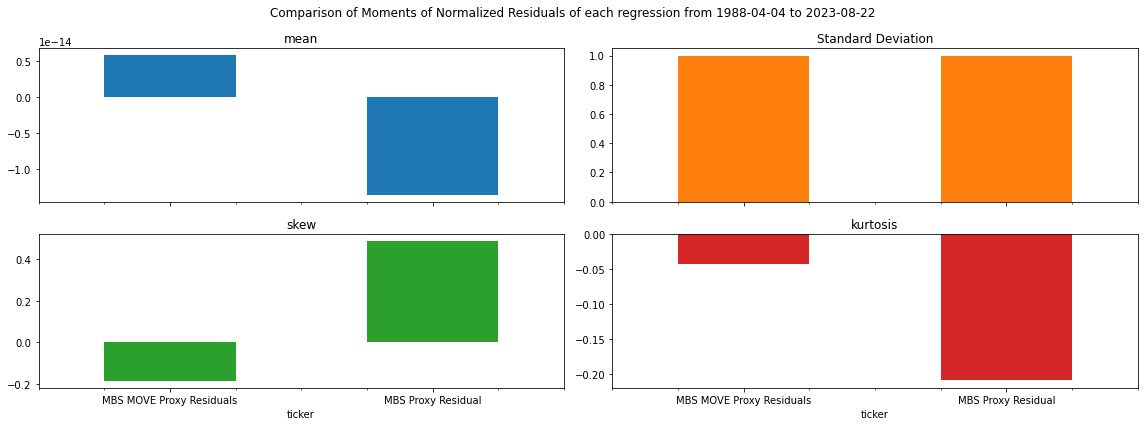

In [20]:
(df_resid_moment.reset_index().drop(
    columns = ["level_1"]).
    set_index("ticker").
    plot(
        kind = "bar",
        subplots = True,
        layout = (2,2),
        legend = False,
        rot = 360,
        figsize = (16, 6),
        title = "Comparison of Moments of Normalized Residuals of each regression from {} to {}".format(
            df_tmp.index.min().date(),
            df_tmp.index.max().date())))

plt.tight_layout()
plt.show()

# Analyzing Spreads

In [68]:
df_spread = (df_mbs_model.assign(
    mbs_proxy = lambda x: x["30y FNCL Par Coupon"] - x["TSY MBS Proxy"]).
    reset_index().
    merge(
        right = df.query("ticker == 'MOVE Index'").drop(columns = "ticker").rename(columns = {"value": "MOVE"}),
        how = "inner",
        on = ["date"]).
    assign(move_mbs = lambda x: x.MOVE * 0.014049).
    drop(columns = ["MOVE"]).
    set_index("date").
    rename(columns = {
        "mbs_proxy": "MBS Proxy",
        "move_mbs": "MOVE Proxy",
        "mbs_vol_proxy": "MBS-MOVE Proxy"}))

In [90]:
df_spread_duration = (df_spread.assign(
    spread = lambda x: x["MOVE Proxy"] - x["MBS Proxy"])
    ["spread"].
    reset_index().
    merge(right = df.query("ticker == 'LUMSMD Index'").drop(columns = ["ticker"]), how = "inner", on = ["date"]).
    set_index("date"))

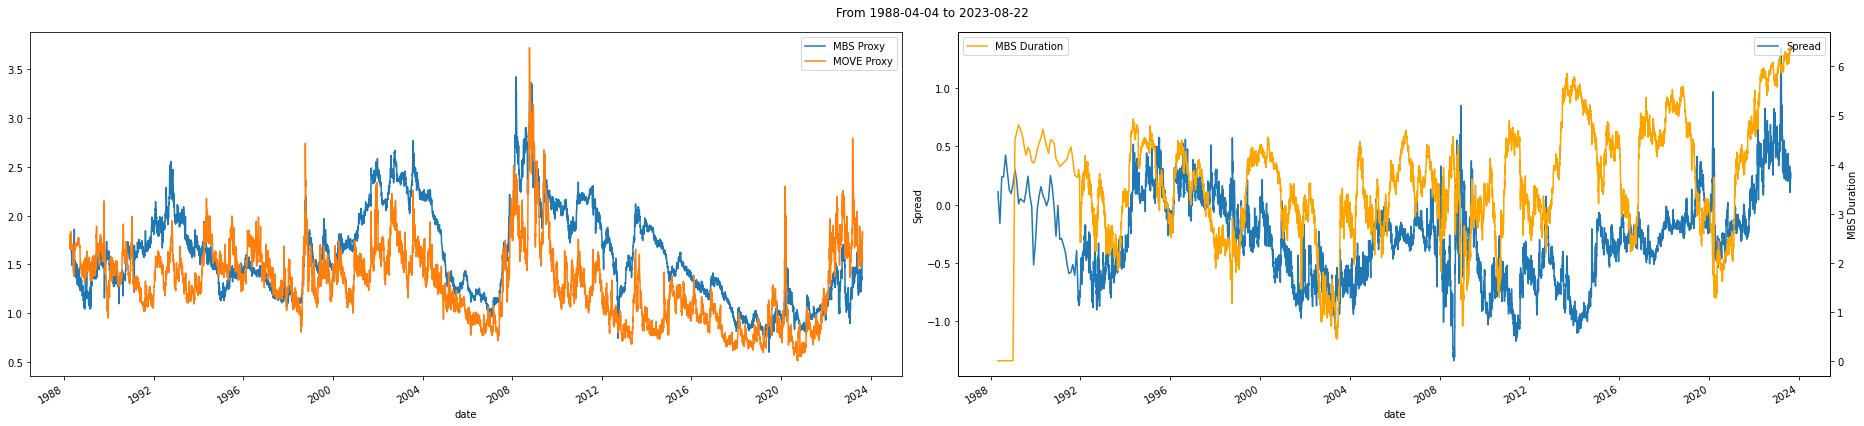

In [103]:
fig, axes = plt.subplots(ncols = 2, figsize = (26,6))

(df_spread[
    ["MBS Proxy", "MOVE Proxy"]].
    plot(
        ax = axes[0]))

axes1_copy = axes[1].twinx()
(df_spread_duration[
    ["spread"]].
    rename(columns = {"spread": "Spread"}).
    plot(
        ax = axes[1],
        ylabel = "Spread"))

(df_spread_duration[
    ["value"]].
    rename(columns = {"value": "MBS Duration"}).
    plot(
        ax = axes1_copy, 
        color = "orange",
        ylabel = "MBS Duration"))

axes1_copy.legend(loc = "upper left")
axes[1].legend(loc = "upper right")

fig.suptitle("From {} to {}".format(
    df_spread.index.min().date(),
    df_spread.index.max().date()))

plt.tight_layout()
plt.show()